In [0]:
import torch
import torchvision
import torchvision.models as models

In [2]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/project dl")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
![ ! -d "CUB_200_2011" ] && tar -xzvf "{AUX_DATA_ROOT / 'CUB_200_2011.tgz'}"
![ ! -d "embeddings" ] && unzip -q "{AUX_DATA_ROOT / 'embeddings.zip'}"

Streaming output truncated to the last 5000 lines.
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0004_111989.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0127_111935.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0028_113217.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0126_110959.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0007_111029.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0120_113001.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0010_112678.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0025_111669.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0084_111300.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0002_112905.j

In [0]:
NO_EMBEDDINGS = False

In [0]:
if NO_EMBEDDINGS:
    vgg16 = models.vgg16(pretrained=True).cuda()
    vgg16.eval()

In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [0]:
landmarks_frame = pd.read_csv('./CUB_200_2011/parts/part_locs.txt', sep=" ", header=None)
images_names = pd.read_csv("./CUB_200_2011/images.txt", header=None)

In [0]:
landmarks = []
for i in range(0, 176805, 15):
    landmarks_temp = []
    for j in range(i, i + 15):
        landmarks_temp.append(landmarks_frame.iloc[j, 2:])
    landmarks_temp = np.asarray(landmarks_temp)
    landmarks.append(landmarks_temp.astype('float').reshape(-1, 3))

In [0]:
def show_landmarks(image, landmarks, colors):
    """Show image with landmarks"""

    marks_colors = list(filter(lambda x: x[1][2] == 1, zip(colors, list(landmarks))))
    colors = [x[0] for x in marks_colors]
    landmarks = np.array([x[1] for x in marks_colors])
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c=colors)
    plt.pause(0.001)

In [0]:
class BirdLandmarksDataset(Dataset):

    def __init__(self, landmarks_frame, root_dir, image_names, transform=None):
        self.landmarks_frame = landmarks_frame
        self.root_dir = root_dir
        self.transform = transform
        self.image_names = image_names

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = f"{self.root_dir}{self.image_names.iloc[idx][0].split()[1]}"
        image = io.imread(img_name)
        landmarks = self.landmarks_frame[idx]
        sample = {'image': image, 'landmarks': landmarks, 'name' : img_name}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
class RescaleNormalize(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __call__(self, sample):
        image, landmarks, name = sample['image'], sample['landmarks'], sample['name']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        img = torch.from_numpy(img)
        if len(img.shape) == 2:
            img = torch.stack((img, img, img))
        else:
          img = torch.transpose(img, 0, 2)
          img = torch.transpose(img, 1, 2)
        img = self.normalize(img)
        landmarks = landmarks[:, :2] * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks, 'name': name}

In [0]:
transformation = RescaleNormalize((224, 224))
dataset = BirdLandmarksDataset(landmarks, "./CUB_200_2011/images/", images_names, transformation)

In [0]:
#mkdir embeddings

In [0]:
if NO_EMBEDDINGS:
    embeddings = []
    for i in range(len(dataset)):
        sample = dataset[i]
        relu_4_2 = vgg16.features[:21](sample['image'][None, :, :, :].float().cuda())
        relu_5_1 = vgg16.features[:26](sample['image'][None, :, :, :].float().cuda())
        embedding = []
        for j in range(15):
            keypoint_4_2 = (sample['landmarks'] * (27 / 224)).astype(int)[j]
            keypoint_5_1 = (sample['landmarks'] * (13 / 224)).astype(int)[j]
            embedding_kp = torch.zeros((1, 1024)).cuda()
            if not np.all(keypoint_4_2 == [0, 0]):
                kp_embedding_4_2 = relu_4_2[:, :, keypoint_4_2[0], keypoint_4_2[1]]
                kp_embedding_5_1 = relu_5_1[:, :, keypoint_5_1[0], keypoint_5_1[1]]
                embedding_kp = torch.cat((kp_embedding_4_2, kp_embedding_5_1), dim=1)
            embedding.append(embedding_kp)
        torch.save(torch.cat(embedding), f'./embeddings/{i}')

        if i % 100 == 0:
            print(i)

In [0]:
#!zip -r embeddings.zip embeddings

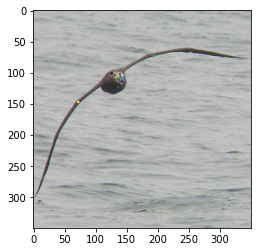

In [16]:
number = 10
plt.figure()
show_landmarks(io.imread(f"./CUB_200_2011/images/{images_names.iloc[number][0].split()[1]}"), \
               landmarks[number], [i for i in range(15)])
plt.show()

In [0]:
x = torch.load(f'./embeddings/{number}')

# dataset of embeddings
### `embeddings_dataset[i]` is the embedding of `dataset[i]['image']`

### each embedding is stored separetely because of memory constraints

### shape of `embeddings_dataset[i]` is `(15, 1024)`, where `15` correspond to the number of parts (`zeros` if this part is not present in the image in other words is not visible).

In [0]:
embeddings_dataset = []
for i in range(len(dataset)):
    embeddings_dataset.append(torch.load(f'./embeddings/{i}'))